Preamble: Import Libraries, Download Dataset, Preprocess Data

In [ ]:

%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # sometimes needed to register 3D
import numpy as np
from matplotlib import colors
from matplotlib.widgets import Slider
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras import layers, models

#initial neural network code
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F


from medmnist import VesselMNIST3D

# Or NoduleMNIST3D, AdrenalMNIST3D, etc.
# Change these to match which dataset you've been assigned


train_dataset = VesselMNIST3D(split='train', size=28, download=True)
trainx = []
trainy = []

test_dataset = VesselMNIST3D(split='test', size=28, download=True)
testx = []
testy = []

val_dataset = VesselMNIST3D(split='train', size=28, download=True)
valx = []
valy = []

for i in range(len(train_dataset)):
    trainx.append(train_dataset[i][0])
    trainy.append(train_dataset[i][1])

for i in range(len(test_dataset)):
    testx.append(test_dataset[i][0])
    testy.append(test_dataset[i][1])

for i in range(len(val_dataset)):
    valx.append(val_dataset[i][0])
    valy.append(val_dataset[i][1])

trainx_tensor = tf.convert_to_tensor(trainx, dtype=tf.float16)
trainy_tensor = tf.convert_to_tensor(trainy, dtype=tf.float16)
testx_tensor = tf.convert_to_tensor(testx, dtype=tf.float16)
testy_tensor = tf.convert_to_tensor(testy, dtype=tf.float16)
valx_tensor = tf.convert_to_tensor(valx, dtype=tf.float16)
valy_tensor = tf.convert_to_tensor(valy, dtype=tf.float16)
# float16 doesn't run any faster on the 4090s, but it cuts memory usage in half!





2025-12-11 17:20:19.862158: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1765491624.444176 1979690 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 876 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:41:00.0, compute capability: 8.9
I0000 00:00:1765491624.445915 1979690 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21759 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:61:00.0, compute capability: 8.9


In [2]:
print("=== VesselMNIST3D Dataset Summary ===\n")

#Training set
print("Training Dataset:")
print("------------------")
print("Number of samples:", len(train_dataset))

img, label = train_dataset[0]

print("Image shape:", img.shape)
print("Label:", label)
print("\n")

#Validation set
print("Validation Dataset:")
print("------------------")
print("Number of samples:", len(val_dataset))

img, label = val_dataset[0]

print("Image shape:", img.shape)
print("Label:", label)
print("\n")

#Test set
print("Test Dataset:")
print("------------------")
print("Number of samples:", len(test_dataset))

img, label = test_dataset[0]

print("Image shape:", img.shape)
print("Label:", label)
print("\n")


=== VesselMNIST3D Dataset Summary ===

Training Dataset:
------------------
Number of samples: 1335
Image shape: (1, 28, 28, 28)
Label: [1]


Validation Dataset:
------------------
Number of samples: 1335
Image shape: (1, 28, 28, 28)
Label: [1]


Test Dataset:
------------------
Number of samples: 382
Image shape: (1, 28, 28, 28)
Label: [1]




In this project, we're using VesselMNIST3D from the MedMNIST collection a set of standardized biomedical image datasets designed for machine learning research. The dataset contains 3D medical images of intracranial anuerysm a life-threatening disease. The dataset is split into the training, validation, and test set. This datasets matters because it allows us to develop and evaluate models ofr 3D image classification.

Our data "VesselMNIST3D" main motivation is the detection and segmentation of intracranial aneurysms. We're identifying abnormal bulges in the cerebral blood vessels and importantly localize the neck of the aneurysm. The neck is the boundary which is critical for planning surgical treatment. The goals are diagnosis/classification and segmentation (identfying the neck) using 3D models helps better because of the shape and fine geometry.

The outputs printed above summarize the structure of the VesselMNIST3D dataset used for this project. The 3D medical images are 28x28x28 relevant to intracranial aneurysm detection. From this summary we can conclude our neural network must process 3D volumetric data and the output is a single binary classification, and the dataset is balanced enough to train a reliable 3D CNN or ResNet.



Preamble: Understand and Visualize Data

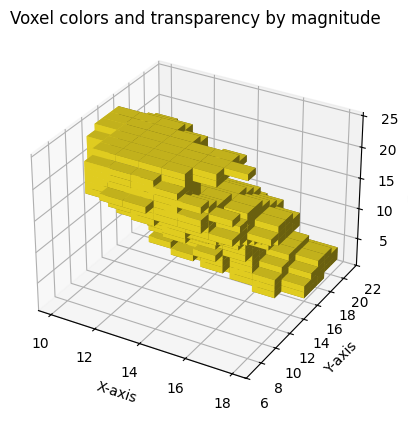

In [3]:
fig = plt.figure()

vol = np.squeeze(trainx[1], axis=0)     # shape (28, 28, 28)

ax = fig.add_subplot(111, projection='3d')

filled = vol > 0

# Create RGBA array
norm = colors.Normalize(vmin=vol.min(), vmax=vol.max())

# Pick a colormap: 'viridis', 'plasma', 'inferno', 'magma', etc.
cmap = plt.cm.viridis

# cmap(norm(vol)) gives an RGBA array of shape (28, 28, 28, 4)
facecolors = cmap(norm(vol))

# --- Use magnitude as alpha (0 → transparent, 1 → opaque) ---
# If vol is already in [0, 1], clip is fine; otherwise you can reuse norm(vol)
alpha = np.clip(vol, 0, 1)
facecolors[..., 3] = alpha

# Optionally: make truly empty voxels fully transparent (even if they exist in facecolors)
facecolors[~filled, 3] = 0.0

# --- Plot ---
ax.voxels(filled, facecolors=facecolors)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.title('Voxel colors and transparency by magnitude')
plt.show()

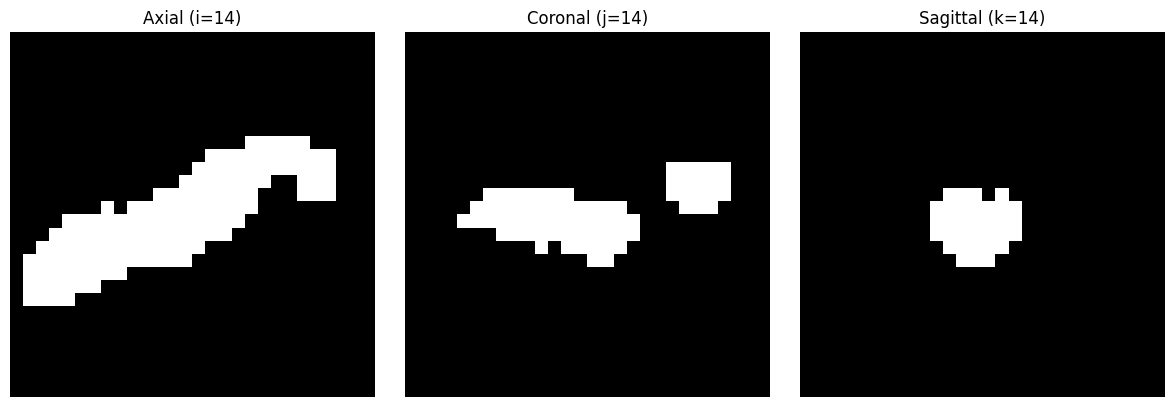

In [4]:
# Middle indices along each axis
i_mid = vol.shape[0] // 2  # axial index
j_mid = vol.shape[1] // 2  # coronal index
k_mid = vol.shape[2] // 2  # sagittal index

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Axial: slice along axis 0
axes[0].imshow(vol[i_mid, :, :], cmap='gray')
axes[0].set_title(f'Axial (i={i_mid})')
axes[0].axis('off')

# Coronal: slice along axis 1
axes[1].imshow(vol[:, j_mid, :], cmap='gray')
axes[1].set_title(f'Coronal (j={j_mid})')
axes[1].axis('off')

# Sagittal: slice along axis 2
axes[2].imshow(vol[:, :, k_mid], cmap='gray')
axes[2].set_title(f'Sagittal (k={k_mid})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

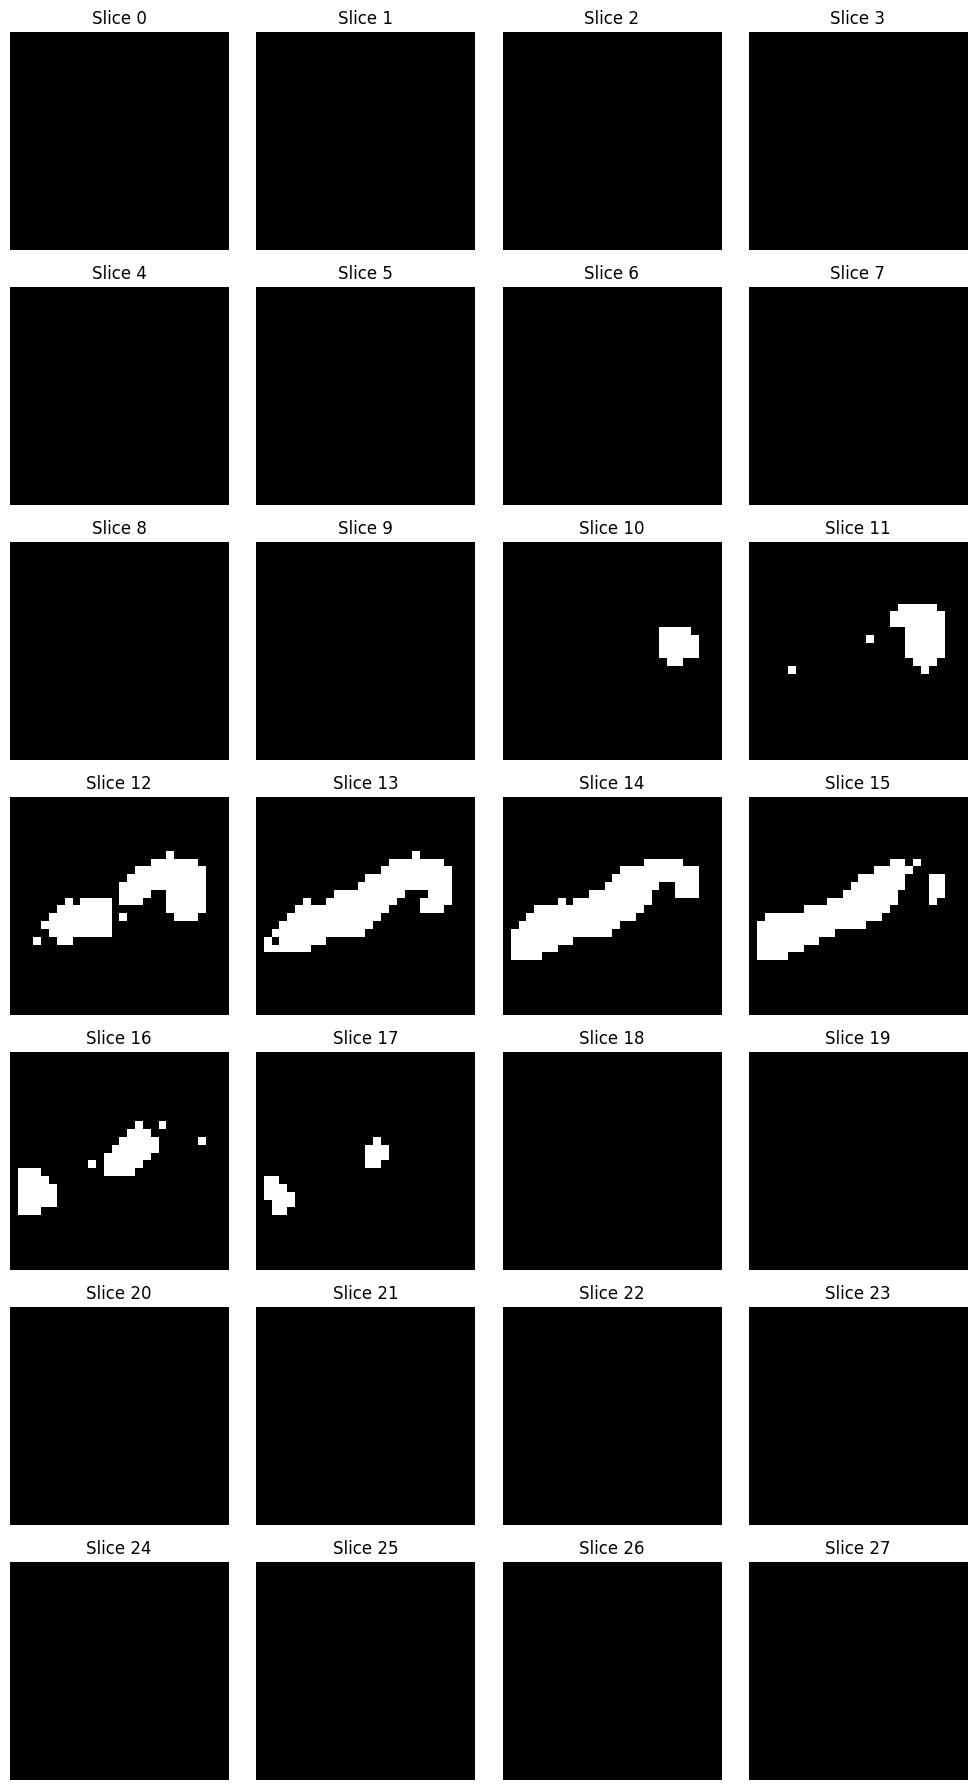

In [5]:
num_slices = vol.shape[0]
rows, cols = 7, 4

fig, axes = plt.subplots(rows, cols, figsize=(10, 18))

for i, ax in enumerate(axes.flat):
    if i < num_slices:
        ax.imshow(vol[i], cmap='gray')
        ax.set_title(f"Slice {i}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# class Vessel3DCNN(nn.Module):
#     def __init__(self, in_channels=1, num_classes=2):
#         super().__init__()
        
#         # Block 1
#         self.conv1 = nn.Conv3d(in_channels, 16, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool3d(2)   # 28 -> 14
        
#         # Block 2
#         self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        
        
#         self.globalpool = nn.AdaptiveAvgPool3d(1)
        
        
#         self.fc = nn.Linear(128, num_classes)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = self.pool(F.relu(self.conv2(x)))
        
#         x = F.relu(self.conv3(x))
#         x = self.pool(F.relu(self.conv4(x)))
        
#         x = self.globalpool(x)
#         x = x.view(x.size(0), -1)
#         return self.fc(x)

In [ ]:
# class ToTensorDataset(torch.utils.data.Dataset):
#     def __init__(self, dataset):
#         self.dataset = dataset

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         img, label = self.dataset[idx]
#         # Convert numpy -> torch tensor
#         img = torch.tensor(img, dtype=torch.float32)
#         label = torch.tensor(label, dtype=torch.long)
#         # Ensure correct shape: [1, 28, 28, 28]
#         if img.ndim == 3:
#             img = img.unsqueeze(0)
#         return img, label

# train_dataset = ToTensorDataset(train_dataset)
# test_dataset  = ToTensorDataset(test_dataset)

# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
def build_3d_cnn(input_shape=(28,28,28,1), num_classes=2):
    inputs = layers.Input(shape=input_shape)
    
    # Block 1
    x = layers.Conv3D(16, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.Conv3D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPooling3D(pool_size=2)(x)  # 28 -> 14
    
    # Block 2
    x = layers.Conv3D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv3D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPooling3D(pool_size=2)(x)  # 14 -> 7
    
    # Global Pooling + Dense
    x = layers.GlobalAveragePooling3D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model




In [ ]:
#loss and optimizer
# model = Vessel3DCNN(in_channels=1, num_classes=2)
model = build_3d_cnn()
model.summary()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score

# Make sure your data has shape [num_samples, 28, 28, 28, 1]
trainx_tensor = tf.expand_dims(trainx_tensor, axis=-1)
testx_tensor  = tf.expand_dims(testx_tensor, axis=-1)

# Build model
model = build_3d_cnn(input_shape=(28,28,28,1), num_classes=2)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

num_epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

batch_size = 8
train_dataset = tf.data.Dataset.from_tensor_slices((trainx_tensor, trainy_tensor)).shuffle(1000).batch(batch_size)
val_dataset   = tf.data.Dataset.from_tensor_slices((testx_tensor, testy_tensor)).batch(batch_size)

for epoch in range(num_epochs):
    # --- Training ---
    epoch_train_loss = 0
    train_preds = []
    train_labels = []

    for images, labels in train_dataset:
        with tf.GradientTape() as tape:
            outputs = model(images, training=True)
            loss = tf.keras.losses.sparse_categorical_crossentropy(labels, outputs)
        grads = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        epoch_train_loss += tf.reduce_mean(loss).numpy()
        train_preds.extend(tf.argmax(outputs, axis=1).numpy())
        train_labels.extend(labels.numpy())

    epoch_train_loss /= len(train_dataset)
    epoch_train_acc = accuracy_score(train_labels, train_preds)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # --- Validation ---
    epoch_val_loss = 0
    val_preds = []
    val_labels = []

    for images, labels in val_dataset:
        outputs = model(images, training=False)
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, outputs)
        epoch_val_loss += tf.reduce_mean(loss).numpy()
        
        val_preds.extend(tf.argmax(outputs, axis=1).numpy())
        val_labels.extend(labels.numpy())

    epoch_val_loss /= len(val_dataset)
    epoch_val_acc = accuracy_score(val_labels, val_preds)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}")
    print(f"  Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")
    print("-" * 50)


In [ ]:
# model = Vessel3DCNN(in_channels=1, num_classes=2)
# # model = build_3d_cnn(in_channels=1, num_classes=2)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# num_epochs = 10

# for epoch in range(num_epochs):
#     # Training
#     model.train()
#     running_loss = 0.0
#     train_preds = []
#     train_labels = []
    
#     for images, labels in train_loader:
#         images = images.float()
#         labels = labels.squeeze().long()
        
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#         _, predicted = torch.max(outputs.data, 1)
#         train_preds.extend(predicted.cpu().numpy())
#         train_labels.extend(labels.cpu().numpy())
    
#     epoch_train_loss = running_loss / len(train_loader)
#     epoch_train_acc = accuracy_score(train_labels, train_preds)
#     train_losses.append(epoch_train_loss)
#     train_accuracies.append(epoch_train_acc)
    
#     # Validation
#     model.eval()
#     val_running_loss = 0.0
#     val_preds = []
#     val_labels = []
    
#     with torch.no_grad():
#         for images, labels in test_loader:
#             images = images.float()
#             labels = labels.squeeze().long()
            
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             val_running_loss += loss.item()
            
#             _, predicted = torch.max(outputs.data, 1)
#             val_preds.extend(predicted.cpu().numpy())
#             val_labels.extend(labels.cpu().numpy())
    
#     epoch_val_loss = val_running_loss / len(test_loader)
#     epoch_val_acc = accuracy_score(val_labels, val_preds)
#     val_losses.append(epoch_val_loss)
#     val_accuracies.append(epoch_val_acc)
    
#     print(f"Epoch {epoch+1}/{num_epochs}")
#     print(f"  Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}")
#     print(f"  Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")
#     print("-" * 50)

Epoch 1/10
  Train Loss: 0.3819 | Train Acc: 0.8772
  Val Loss: 0.3517 | Val Acc: 0.8874
--------------------------------------------------
Epoch 2/10
  Train Loss: 0.3702 | Train Acc: 0.8876
  Val Loss: 0.3567 | Val Acc: 0.8874
--------------------------------------------------
Epoch 3/10
  Train Loss: 0.3547 | Train Acc: 0.8876
  Val Loss: 0.3736 | Val Acc: 0.8874
--------------------------------------------------
Epoch 4/10
  Train Loss: 0.3401 | Train Acc: 0.8876
  Val Loss: 0.3180 | Val Acc: 0.8874
--------------------------------------------------
Epoch 5/10
  Train Loss: 0.3428 | Train Acc: 0.8884
  Val Loss: 0.3299 | Val Acc: 0.8874
--------------------------------------------------
Epoch 6/10
  Train Loss: 0.3249 | Train Acc: 0.8876
  Val Loss: 0.3419 | Val Acc: 0.8691
--------------------------------------------------
Epoch 7/10
  Train Loss: 0.3233 | Train Acc: 0.8861
  Val Loss: 0.3189 | Val Acc: 0.8639
--------------------------------------------------
Epoch 8/10
  Train L

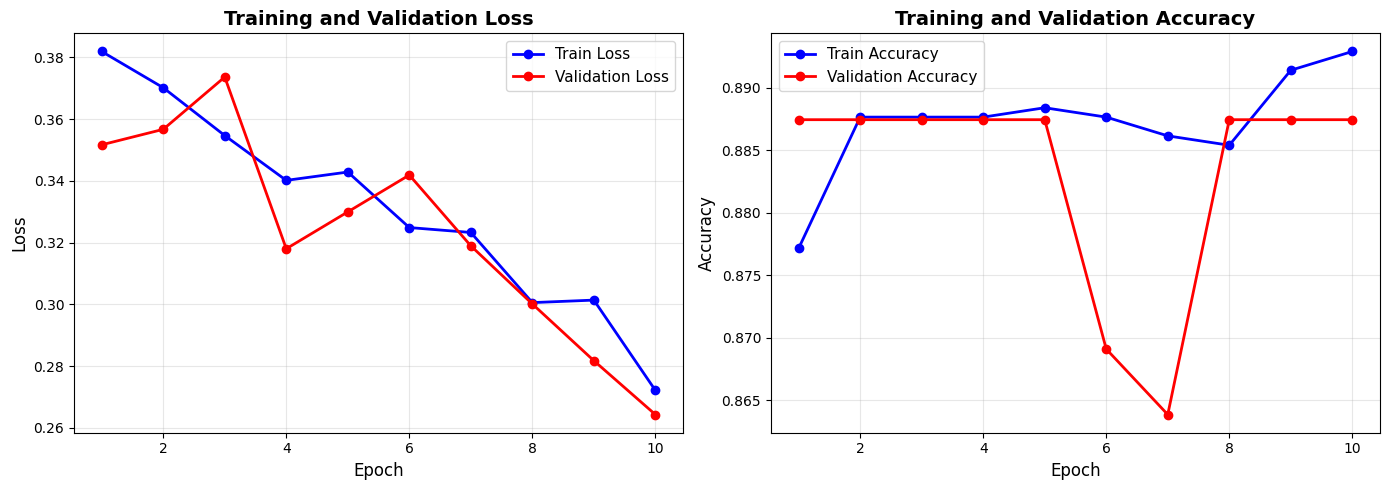

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, num_epochs + 1)
# Loss plot
ax1.plot(epochs_range, train_losses, 'b-o', label='Train Loss', linewidth=2)
ax1.plot(epochs_range, val_losses, 'r-o', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(epochs_range, train_accuracies, 'b-o', label='Train Accuracy', linewidth=2)
ax2.plot(epochs_range, val_accuracies, 'r-o', label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

This code fulfills milestone 2 requirements for our dataset VesselMNIST. Our goal for milestone 2 is to build a initial neural network architecture, choose an appropriate loss function and then run 1-2 test epochs locally.

Our data consists of 3D medical image volumes (28x28x28) so the model must output class logits for each image. We implemented 3D convolutional neural network. To satisfy milestone 2 we trained the model for 2 test epochs on local computer and the result we got is printed above. In conclusion, we've an appropriate loss function and our model trains successfully for 1-2 epochs.